In [2]:
pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# import tensorflow dependencies
from tensorflow.keras.layers import Layer, Dense, Conv2D,MaxPooling2D, Input,Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

In [5]:
# avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
len(gpus)

0

In [7]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
POS_PATH

'data\\positive'

In [7]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
#http://vis-www.cs.umass.edu/Lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the wild dataset
!tar -xf lfw.tgz

In [7]:
# move lfw images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory,file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [8]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        print(os.path.join('lfw',directory, file))
        

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [9]:
# import uuid library to generate unique image names
import uuid


In [10]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\ac3e2576-3a9c-11ef-bc3a-50c2e88f1ff0.jpg'

In [11]:
# Establish a connection to the webcam

cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret,frame =cap.read()
    
    #Cut down frame to 250*250 px
    frame= frame[200:200+250,200:200+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF ==ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname, frame)
    
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF ==ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname, frame)
    
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    #Breaking gracefully
    if cv2.waitKey(1) & 0XFF ==ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show/frame
cv2.destroyAllWindows()

frame


In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
dir_test.next()

b'data\\anchor\\cfd4a1cc-3577-11ef-ba09-50c2e88f1ff0.jpg'

In [16]:
def preprocess(file_path):
    
    # read in image from a file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # preprocessing steps - resizing the image to be 100*100*3
    img = tf.image.resize(img, (100,100))
    # scale image to be between 0 and 1
    img = img/255.0
    return img

In [17]:
img = preprocess('data\\anchor\\70b0e336-35d8-11ef-bb99-50c2e88f1ff0.jpg')

In [19]:
# (anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
samples = data.as_numpy_iterator()

In [22]:
example = samples.next()
len(example)
example[2]

1.0

In [23]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [24]:
example

(b'data\\anchor\\9665e9ca-3577-11ef-b117-50c2e88f1ff0.jpg',
 b'data\\positive\\59cf65ee-35d8-11ef-b478-50c2e88f1ff0.jpg',
 1.0)

In [25]:
res = preprocess_twin(*example)

In [26]:
len(res)

3

In [27]:
res[2]

1.0

In [28]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [29]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [30]:
samples = data.as_numpy_iterator()

In [31]:
samp = samples.next()

0.0

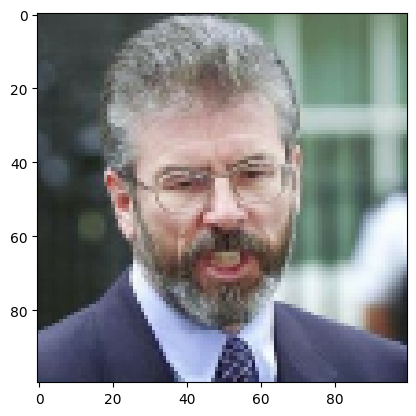

In [32]:
plt.imshow(samp[1])
samp[2]

In [33]:
len(data)

600

In [34]:
 # training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [35]:
train_samples = train_data.as_numpy_iterator()

In [36]:
# testing partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [37]:
# building embedding layer

def make_embedding():
    inp = Input(shape=(100,100,3), name = 'Input image')
    # First block
    c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # third block
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # final embedding block
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    

        
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
embedding = make_embedding()

In [39]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [40]:
# build distance layer

# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [41]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name = 'input_img', shape=(100,100,3))
    
    # Validation image in the network
    validation_image = Input(name = 'Validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [42]:
siamese_model = make_siamese_model()

In [43]:
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 Validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]    

In [44]:
# build train step function

test_batch = train_data.as_numpy_iterator()


In [45]:
batch_1 = test_batch.next()

In [46]:
batch_1[2]

array([0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
      dtype=float32)

In [47]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [48]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [49]:
# establish checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix =os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [50]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        
        # Forward pass
        yhat = siamese_model(X, training = True)
        print(f"Using scope: {siamese_model.name}")  # Print scope name
        # Calculate Loss
        loss = binary_cross_loss(y, yhat)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return Loss
    return loss

In [51]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch  {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            #Run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        # save checkpoints
        if epoch % 10 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            

In [59]:
EPOCHS = 50

In [60]:
train(train_data, EPOCHS)


 Epoch  1/50
Using scope: Siamese_Network
Using scope: Siamese_Network
27/27 [==============================] - 1075s 40s/step

 Epoch  2/50
27/27 [==============================] - 1554s 19s/step

 Epoch  3/50
27/27 [==============================] - 534s 20s/step

 Epoch  4/50
27/27 [==============================] - 525s 19s/step

 Epoch  5/50
27/27 [==============================] - 513s 19s/step

 Epoch  6/50
27/27 [==============================] - 525s 19s/step

 Epoch  7/50
27/27 [==============================] - 538s 20s/step

 Epoch  8/50
27/27 [==============================] - 521s 19s/step

 Epoch  9/50
27/27 [==============================] - 524s 19s/step

 Epoch  10/50
27/27 [==============================] - 486s 18s/step

 Epoch  11/50
27/27 [==============================] - 461s 17s/step

 Epoch  12/50
27/27 [==============================] - 454s 17s/step

 Epoch  13/50
27/27 [==============================] - 471s 17s/step

 Epoch  14/50
27/27 [=================

In [68]:


# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [69]:
# Get a batch of test data

test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [70]:
# make predictions
y_hat = model.predict([test_input, test_val])
y_hat

array([[0.50007665],
       [0.4987998 ],
       [0.49940488],
       [0.49924088],
       [0.49965736],
       [0.4998876 ],
       [0.49885145],
       [0.49876034],
       [0.49916422],
       [0.4995363 ],
       [0.49936342],
       [0.498783  ],
       [0.49910757],
       [0.5004819 ],
       [0.49958518],
       [0.50013447]], dtype=float32)

In [71]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]

In [72]:
y_true

array([1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [62]:
# creating a metric onbject
m = Recall()

m.update_state(y_true, y_hat)

# return recall result
m.result().numpy()

0.125

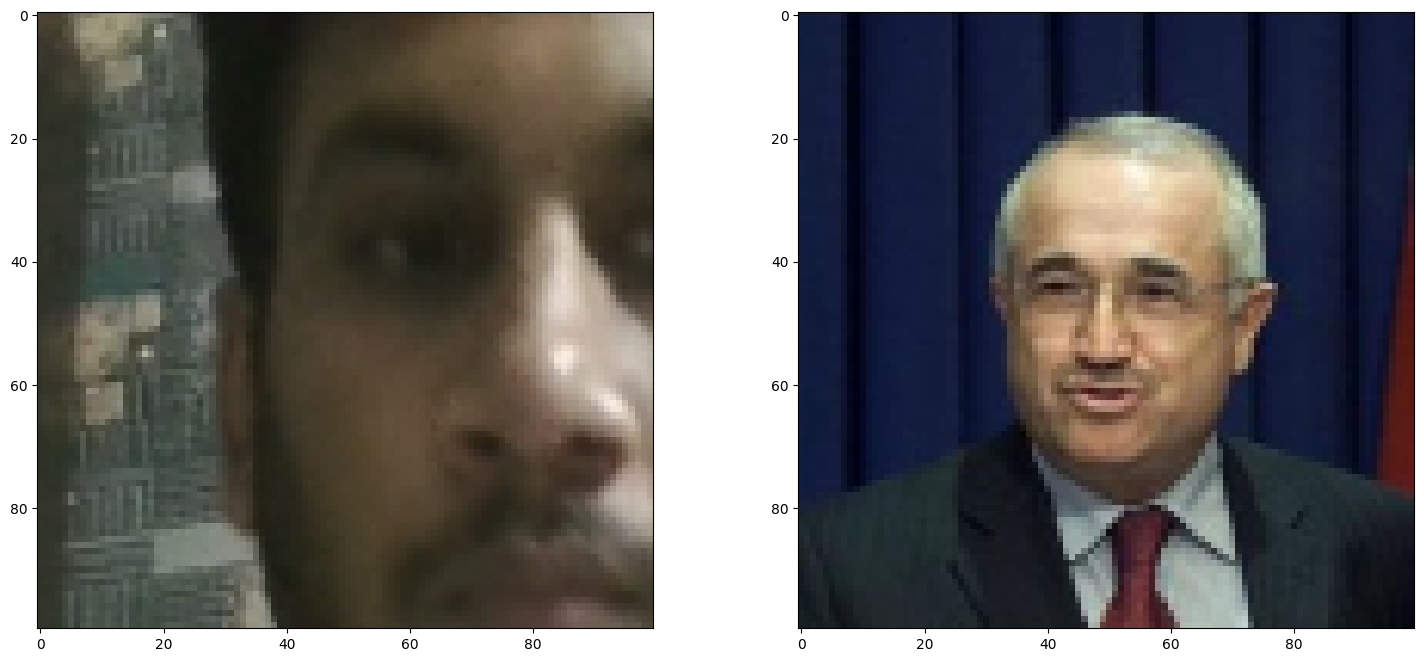

In [63]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[8])
plt.subplot(1,2,2)
plt.imshow(test_val[8])
plt.show()


In [64]:
# save model

# save weights
siamese_model.save('siamesemodel.h5')
 

In [67]:
# reload model
from tensorflow.keras.models import load_model
model = load_model('siamesemodel.h5',custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [56]:
model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 Validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]    

In [109]:
# save weights
siamese_model.save_weights('siamesemodel_weights.h5')

# load weights
siamese_model.load_weights('siamesemodel_weights.h5')

In [73]:
# make predictions with reloaded model
model.predict([test_input, test_val])

array([[0.50007665],
       [0.4987998 ],
       [0.49940488],
       [0.49924088],
       [0.49965736],
       [0.4998876 ],
       [0.49885145],
       [0.49876034],
       [0.49916422],
       [0.4995363 ],
       [0.49936342],
       [0.498783  ],
       [0.49910757],
       [0.5004819 ],
       [0.49958518],
       [0.50013447]], dtype=float32)

In [111]:
# view our model summary
model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 Validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_13 (L1Dist)             (None, 4096)         0           embedding[0][0]    

# real time test

# verification function


In [112]:
def verify(frame, model, detection_theshold, verification_threshold):
    # Build results array
    results=[]
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('applcation_data', 'verification_images', image))
        
        # make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    # detection threshold : metric above which a prediction is considered positive    
    detection = np.sum(np.array(results) > detection_threshold)
    
    #  verification threshold : proportion of positive predictions/ total possitive samples
    verification = detection / len(os.listdir(os.path.join('applcation_data', 'verification_images')))
    verified = verification / verification_threshold
    
    
    return results, verified
        
    # detection threshold : metric above with a prediction is considered positive
    # verification threshold : proportion of positive predictions/ total possitive samples
    

# opencv realtime verificATION

In [113]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame= frame[200:200+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # run verification
        results, verified = verify(frame, model, 0.5, 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NotFoundError: NewRandomAccessFile failed to Create/Open: applcation_data\verification_images\3f1413be-35d8-11ef-a32b-50c2e88f1ff0.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]